# Выбор локации для скважины

Мы работаем в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Нам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Нужно построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируем возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

In [70]:
!pip install optuna -q

In [71]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats as st
from matplotlib.collections import PathCollection  # для отображения легенды
from matplotlib.legend_handler import HandlerPathCollection, HandlerLine2D # для отображения легенды
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
%matplotlib inline

import optuna
from optuna.visualization.matplotlib import plot_param_importances
from optuna.samplers import TPESampler

In [72]:
# установка параметров системы
pd.options.display.max_columns = 100  # чтоб выводил все столбцы на экран
pd.options.display.float_format = '{:,.2f}'.format # отображение количества знаков после запятой
optuna.logging.set_verbosity(optuna.logging.ERROR) # убираем логи в optuna
sns.set_style("darkgrid")

In [73]:
try:
    df1 = pd.read_csv(
        "https://code.s3.yandex.net/datasets/geo_data_0.csv"
    )  # скачиваем датасет
    df2 = pd.read_csv(
        "https://code.s3.yandex.net/datasets/geo_data_1.csv"
    )  # скачиваем датасет
    df3 = pd.read_csv(
        "https://code.s3.yandex.net/datasets/geo_data_2.csv"
    )  # скачиваем датасет
except:
    print("ошибка связи с сетью")
try:
  df1.shape # проверка на существование датасета
except:
  try:
    df1 = pd.read_csv("/datasets/geo_data_0.csv")  # если нет интернета
    df2 = pd.read_csv("/datasets/geo_data_1.csv")  # если нет интернета
    df3 = pd.read_csv("/datasets/geo_data_2.csv")  # если нет интернета
  except:
    print("ошибка чтения с диска")


## Загрузка и подготовка данных

### Первичное ознакомление

Получим общую информацию о таблице:

In [74]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [75]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [76]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


Согласно документации к данным:

    f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
    product — объём запасов в скважине (тыс. баррелей).

Выведем на экран первые пять строк таблиц:

In [77]:
df1.head()

,id,f0,f1,f2,product
0,txEyH,0.71,-0.50,1.22,105.28
1,2acmU,1.33,-0.34,4.37,73.04
2,409Wp,1.02,0.15,1.42,85.27
3,iJLyR,-0.03,0.14,2.98,168.62
4,Xdl7t,1.99,0.16,4.75,154.04


In [78]:
df2.head()

,id,f0,f1,f2,product
0,kBEdx,-15.00,-8.28,-0.01,3.18
1,62mP7,14.27,-3.48,1.00,26.95
2,vyE1P,6.26,-5.95,5.00,134.77
3,KcrkZ,-13.08,-11.51,5.00,137.95
4,AHL4O,12.70,-8.15,5.00,134.77


In [79]:
df3.head()

,id,f0,f1,f2,product
0,fwXo0,-1.15,0.96,-0.83,27.76
1,WJtFt,0.26,0.27,-2.53,56.07
2,ovLUW,0.19,0.29,-5.59,62.87
3,q6cA6,2.24,-0.55,0.93,114.57
4,WPMUX,-0.52,1.72,5.90,149.60


Данные синтетические: детали контрактов и характеристики месторождений не разглашаются. Что подразумевают под собой признаки f1,f2,f0 мы не можем узнать. Поэтому в своих действиях относительно анализа мы ограничены.

Создадим переменную, где будут храниться все таблицы с данными.

In [80]:
dfs = [df1,df2,df3]

Посмотрим на распределения значений внутри таблиц:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  


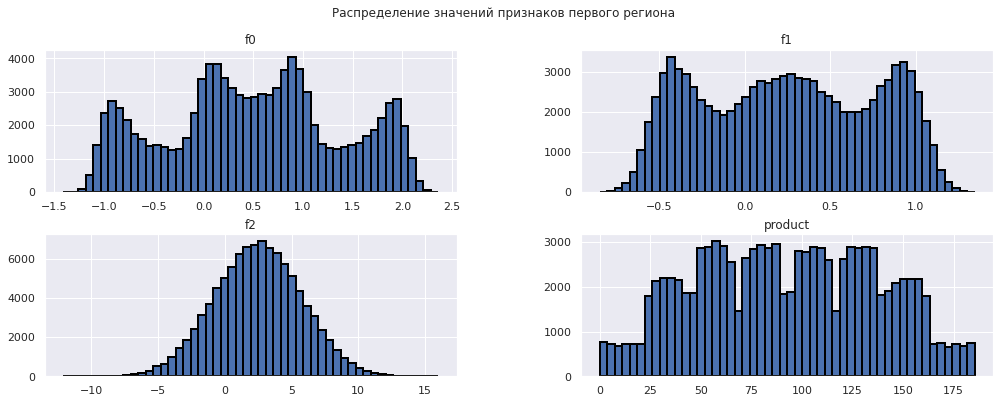

In [81]:
fig, ax = plt.subplots(figsize=(17,6))
df1.hist(    bins=50, figsize=(20, 15), edgecolor="black", linewidth=2, ax=ax)
plt.suptitle("Распределение значений признаков первого региона")
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  


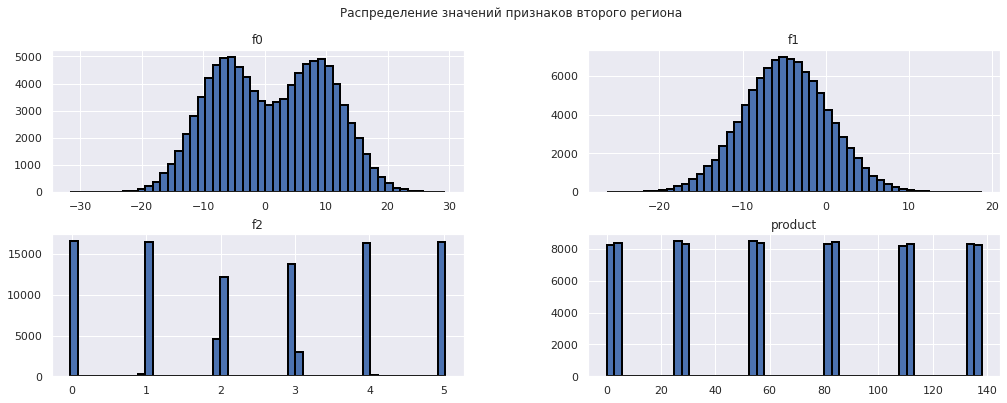

In [82]:
fig, ax = plt.subplots(figsize=(17,6))
df2.hist(    bins=50, figsize=(20, 15), edgecolor="black", linewidth=2, ax=ax)
fig.suptitle("Распределение значений признаков второго региона")
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  


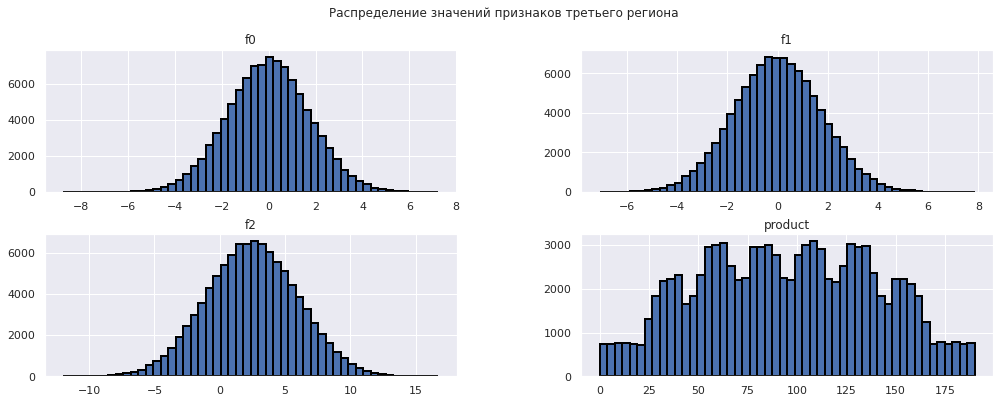

In [83]:
fig, ax = plt.subplots(figsize=(17,6))
df3.hist(    bins=50, figsize=(20, 15), edgecolor="black", linewidth=2, ax=ax)
plt.suptitle("Распределение значений признаков третьего региона")
plt.show()

Заметно, что распределение значений объёма запасов в скважине во втором регионе сильно отличается от распределений запасов в двух остальных регионах.

Посмотрим характеристики значений:

In [84]:
for x in dfs:
  display(x.describe())
  print()

,f0,f1,f2,product
count,"100,000.00","100,000.00","100,000.00","100,000.00"
mean,0.50,0.25,2.50,92.50
std,0.87,0.50,3.25,44.29
min,-1.41,-0.85,-12.09,0.00
25%,-0.07,-0.20,0.29,56.50
50%,0.50,0.25,2.52,91.85
75%,1.07,0.70,4.72,128.56
max,2.36,1.34,16.00,185.36


,f0,f1,f2,product
count,"100,000.00","100,000.00","100,000.00","100,000.00"
mean,1.14,-4.80,2.49,68.83
std,8.97,5.12,1.70,45.94
min,-31.61,-26.36,-0.02,0.00
25%,-6.30,-8.27,1.00,26.95
50%,1.15,-4.81,2.01,57.09
75%,8.62,-1.33,4.00,107.81
max,29.42,18.73,5.02,137.95


,f0,f1,f2,product
count,"100,000.00","100,000.00","100,000.00","100,000.00"
mean,0.00,-0.00,2.50,95.00
std,1.73,1.73,3.47,44.75
min,-8.76,-7.08,-11.97,0.00
25%,-1.16,-1.17,0.13,59.45
50%,0.01,-0.01,2.48,94.93
75%,1.16,1.16,4.86,130.60
max,7.24,7.84,16.74,190.03


Среднее значение объёма запасов в скважине в третьем регионе наиболее высокое. Среднее значение признака f2 почти одинаково во всех регионах.

### Проверка явных дубликатов

In [85]:
for x in dfs:
  print(x.duplicated().sum())

0
0
0


Явные дубликаты не обнаружены.

Проверим корреляцию признаков таблицы:

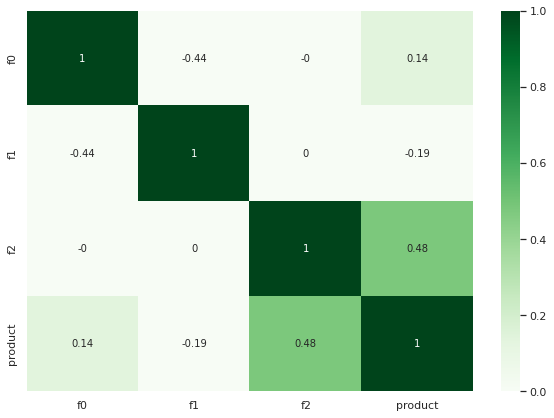

In [86]:
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(data=df1.corr().round(2), annot=True,ax=ax, vmax=1, vmin=0, cmap="Greens")
plt.show()

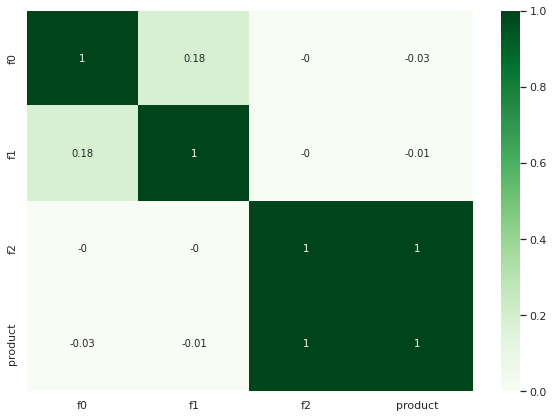

In [87]:
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(data=df2.corr().round(2), annot=True,ax=ax, vmax=1, vmin=0, cmap="Greens")
plt.show()

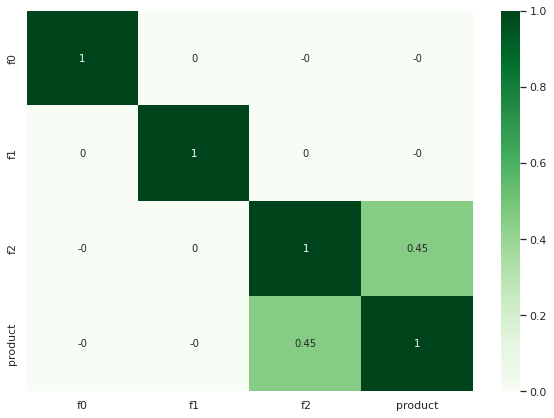

In [88]:
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(data=df3.corr().round(2), annot=True,ax=ax, vmax=1, vmin=0, cmap="Greens")
plt.show()

В первом и третьем регионе заметна корреляция средней выраженности между признаком f2 и целевым признаком, а во втором регионе коэффициент Пирсона равен 1, что означает, что эти признаки полностью взаимосвязаны. Так как мы имеем сильные отличия корреляций в регионах, это больше похоже на странность. <a id='corr'></a>    

### Проверка неявных дубликатов

In [89]:
df1['product'].duplicated().sum()

0

In [90]:
for x in range(len(dfs)):
  for i in df1.columns:
    print(f'В датасете {x+1} признак {i} имеет {dfs[x][i].duplicated().sum()} дубликатов')

В датасете 1 признак id имеет 10 дубликатов
В датасете 1 признак f0 имеет 0 дубликатов
В датасете 1 признак f1 имеет 0 дубликатов
В датасете 1 признак f2 имеет 0 дубликатов
В датасете 1 признак product имеет 0 дубликатов
В датасете 2 признак id имеет 4 дубликатов
В датасете 2 признак f0 имеет 0 дубликатов
В датасете 2 признак f1 имеет 0 дубликатов
В датасете 2 признак f2 имеет 0 дубликатов
В датасете 2 признак product имеет 99988 дубликатов
В датасете 3 признак id имеет 4 дубликатов
В датасете 3 признак f0 имеет 0 дубликатов
В датасете 3 признак f1 имеет 0 дубликатов
В датасете 3 признак f2 имеет 0 дубликатов
В датасете 3 признак product имеет 0 дубликатов


Удивительно много(10%) дубликатов значений столбца `product` во второй таблице. Для определения причин появления их необходимо провести разъяснительную беседу с ответственными за выгрузку данных или принять за факт, что данные синтетические и списать странности на это.

Удалим строки в которых есть дубликаты идентификатора скважины, чтобы при дальнейшем моделировании выручки не взять данные из одной скважины более одного раза. Усредним признаки по этим скважинам:

In [91]:
for x in dfs:
  x = x.groupby(['id'],sort=False, as_index=False).agg('mean')

### Работа с пропусками

Посмотрим, есть ли пропуски в данных:

In [92]:
for x in dfs:
  print(x.isna().sum())
  print()

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64



Пропуски не обнаружены.

### Изменение типа данных


Проверим тип данных в таблицах:

In [93]:
for x in dfs:
  display(x.dtypes)
  print()

id          object
f0         float64
f1         float64
f2         float64
product    float64
dtype: object

id          object
f0         float64
f1         float64
f2         float64
product    float64
dtype: object

id          object
f0         float64
f1         float64
f2         float64
product    float64
dtype: object

Уменьшим битность данных, для ускорения работы с таблицами:

In [94]:
for x in dfs:
  for i in x.select_dtypes(include=["float64"]).columns.tolist():
    x[i] = x[i].astype(np.float32)
  print(x.dtypes)
  print()

id          object
f0         float32
f1         float32
f2         float32
product    float32
dtype: object

id          object
f0         float32
f1         float32
f2         float32
product    float32
dtype: object

id          object
f0         float32
f1         float32
f2         float32
product    float32
dtype: object



### Очистка неиспользуемых данных

Удалим столбец в таблицах не несущий смысла:

In [95]:
for x in dfs:
  del x["id"]

**Вывод**

По итогу, мы имеем три таблицы с тремя признаками точек для потенциальной разработки скважин и с вероятно истинными значениями объемами нефти в них.
На этих данных мы будем обучать наши модели.

В таблицах было немного повторений по `id` скважинам. Это связано с тем, что данные брались несколько раз из одних и тех же скважин. Были удалены задвоения проб с этих скважин.
От столбца `id` мы избавились. При обучении моделей он будет бесполезен.

Чтобы ускорить работу с таблицей, мы уменьшили битность для числовых данных. 

Данные по второму региону имеют странное распределение значений, отличное от других регионов. Очень сильную корреляцию признаков и неестественное задублирование значений.
Для определения причин появления их необходимо провести разъяснительную беседу с ответственными за выгрузку данных или списать все странности на то, что данные синтетические.
Сделаем предположение, что с данными всё в порядке и проведем обучение моделей.



## Обучение и проверка модели

Объявим переменные:

In [96]:
folds = 5  # количество выборок при к-в
trials = 6  # количество итераций для оптимизации
rstate = 12345
sampler = TPESampler(
    seed=10
)  # фиксируем псевдослучайность для оптимизатора чтобы получить воспроизводимый эксперимент.
algorithms = [
    LinearRegression()]  # применяемые модели
algorithms_names = [
    "LinearRegression"    ]  # названия моделей

Создадим функцию, которая переберет гиперпараметры для модели:

In [97]:
# целевая функция
def objective(trial, x, m):
  if m == LinearRegression:  # сделал условие, чтобы потом добавить и другие модели для оптимизации
    param_grid = {
        "fit_intercept": trial.suggest_categorical("fit_intercept", [False, True]),
        "positive": trial.suggest_categorical(       "positive", [False, True]        ),
        "copy_X": trial.suggest_categorical(       "copy_X", [False, True]        ),

    }
    cv = KFold(n_splits=folds, shuffle=True, random_state=rstate)
    features = x.drop(columns='product', axis=1) # отбираем фичи
    target = x['product']  #  назначем целевой признак
    X_train, X_test, y_train, y_test = train_test_split(features,target,  train_size=0.75, random_state=rstate) # разбиваем выборки на тренировочные и проверочные данные
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = pd.DataFrame(scaler.transform(X_train)) # масштабируем признаки
    X_test = pd.DataFrame(scaler.transform(X_test)) # масштабируем признаки
    cv_predicts = []
    for idx, (train_idx, test_idx) in enumerate(cv.split(X_train, y_train)): # блок кроссвалидации
        X_trainCV, X_testCV = X_train.iloc[train_idx], X_train.iloc[test_idx]
        y_trainCV, y_testCV = y_train.iloc[train_idx], y_train.iloc[test_idx]
        model = m( **param_grid)
        model.fit(X_trainCV, y_trainCV)
        preds = model.predict(X_testCV)
        cv_predicts.append(mean_squared_error(y_testCV, preds, squared=False))

    return np.mean(cv_predicts)

Далее сделаем функцию, которая сохранит результаты оптимальной модели:

In [98]:
def lets_predict(x):

  for n in range(len(algorithms)):  
    
    study = optuna.create_study(    direction="minimize", study_name="LinearReg", sampler=sampler)  # устанавливаем задачу получения минимального значения метрики от созданной функции.
    func = lambda trial: objective( trial, x, LinearRegression)  # закидываем на вход датасет и модель
    study.optimize(    func, n_trials=6, show_progress_bar=False)  # запускаем оптимизатор
    #  разбиваем на выборки датасет
    features = x.drop(columns='product', axis=1) # отбираем фичи
    target = x['product']  #  назначем целевой признак
    X_train, X_test, y_train, y_test = train_test_split(features,target,  train_size=0.75, random_state=rstate) # разбиваем выборки на тренировочные и проверочные данные
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = pd.DataFrame(scaler.transform(X_train)) # масштабируем признаки
    X_test = pd.DataFrame(scaler.transform(X_test)) # масштабируем признаки

    model = LinearRegression( **study.best_params) #  создаем модель с лучшими подобранными оптимизатором параметрами
    model.fit(X_train, y_train)        #  обучаем модель
    preds = model.predict(X_train)
    df_report = pd.DataFrame( index = pd.MultiIndex.from_product([algorithms_names, ["train", "test"]], names=["model", "data"]))  # создаем таблицу для заноса метрик
    #  заносим в таблицу метрики для трен данных
    df_report.loc[(algorithms_names[n],'train'), "mae"] = mean_absolute_error(y_train, preds)
    df_report.loc[(algorithms_names[n],'train'), "r2"] = r2_score(y_train, preds)
    df_report.loc[(algorithms_names[n],'train'), "rmse"] = mean_squared_error(y_train, preds, squared=False)
    df_report.loc[(algorithms_names[n],'train'), "mean_pred"] = np.mean(preds)
    df_report.loc[(algorithms_names[n],'train'), "mean_true"] = np.mean(y_train)
    preds = model.predict(X_test)
    #  заносим в таблицу метрики для проверочных данных
    df_report.loc[(algorithms_names[n],'test'), "mae"] = mean_absolute_error(y_test, preds)
    df_report.loc[(algorithms_names[n],'test'), "r2"] = r2_score(y_test, preds)
    df_report.loc[(algorithms_names[n],'test'), "rmse"] = mean_squared_error(y_test, preds, squared=False)
    df_report.loc[(algorithms_names[n],'test'), "mean_pred"] = np.mean(preds)
    df_report.loc[(algorithms_names[n],'test'), "mean_true"] = np.mean(y_test)
    df_preds = pd.DataFrame()  # создаем таблицу для предсказаний и настоящих значений
    df_preds['true_value'] = y_test
    df_preds['predicted'] = preds

  return df_report, model, df_preds

### 1-ый регион

Выполним функцию на данных первого региона:

In [99]:
t = lets_predict(df1)
df_report1 = t[0].copy()
model1 = t[1]
df_predictions1 = t[2].copy()

In [100]:
df_report1

mae   r2  rmse  mean_pred  mean_true
model            data                                        
LinearRegression train 31.08 0.27 37.73      92.64      92.64
                 test  30.92 0.28 37.58      92.59      92.08

Посмотрим соотношение распределений истинных и предсказанных значений на проверочной выборке:

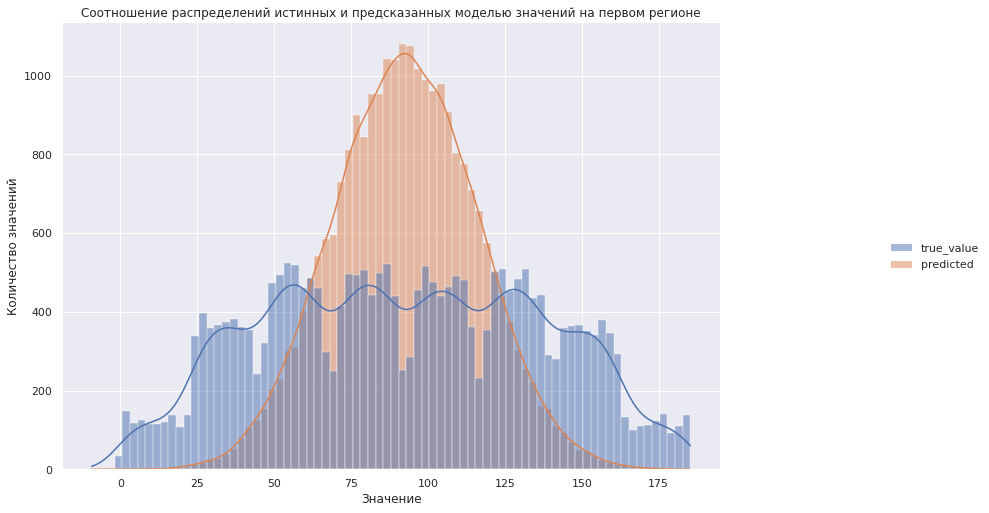

In [101]:
ax = sns.displot(df_predictions1, color='blue', kde=True)
plt.title("Соотношение распределений истинных и предсказанных моделью значений на первом регионе")
plt.ylabel("Количество значений")
plt.xlabel("Значение")
ax.fig.set_size_inches(15,7)

### 2-ой регион

Выполним функцию на данных второго региона:

In [102]:
t = None
t = lets_predict(df2)
df_report2 = t[0].copy()
model2 = t[1]
df_predictions2 = t[2].copy()

In [103]:
df_report2

mae   r2  rmse  mean_pred  mean_true
model            data                                       
LinearRegression train 0.72 1.00  0.89      68.86      68.86
                 test  0.72 1.00  0.89      68.73      68.72

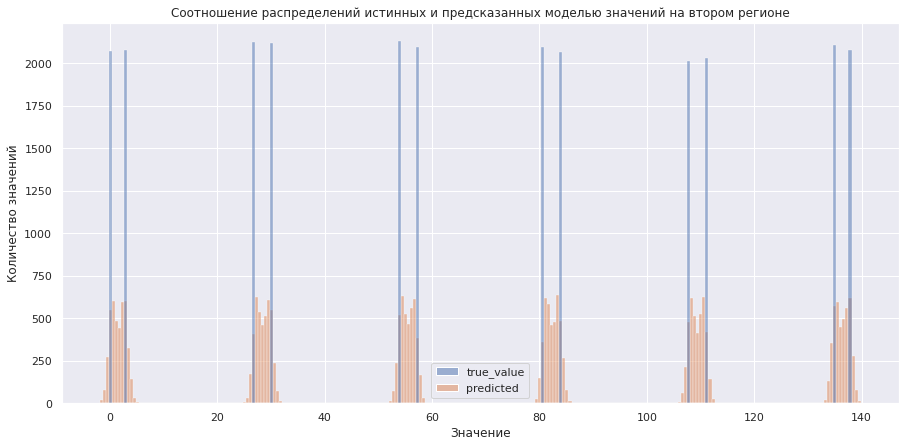

In [104]:
fig, ax = plt.subplots(figsize=(15,7))
plt.title("Соотношение распределений истинных и предсказанных моделью значений на втором регионе")
plt.ylabel("Количество значений")
plt.xlabel("Значение")
ax = sns.histplot(df_predictions2, color='blue', bins=250)

Модель предсказывает с минимальными ошибками. Но распределение изначальных данных вызывает подозрение.

### 3-ий регион

Выполним функцию на данных третьего региона:

In [105]:
t = lets_predict(df3)
df_report3 = t[0].copy()
model3 = t[1]
df_predictions3 = t[2].copy()

In [106]:
df_report3

mae   r2  rmse  mean_pred  mean_true
model            data                                        
LinearRegression train 32.84 0.20 40.06      95.04      95.04
                 test  32.79 0.21 40.03      94.97      94.88

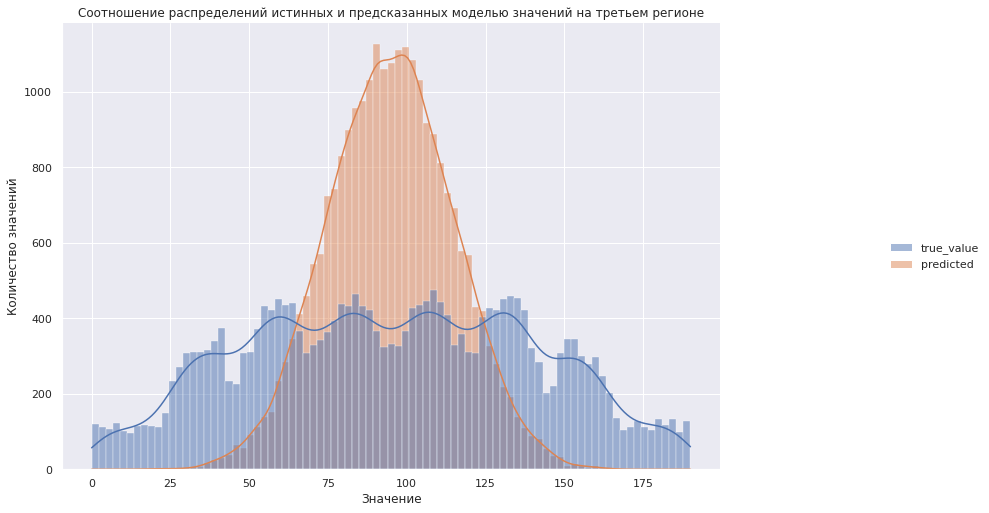

In [107]:
ax = sns.displot(df_predictions3, color='blue', kde=True)
plt.title("Соотношение распределений истинных и предсказанных моделью значений на третьем регионе")
plt.ylabel("Количество значений")
plt.xlabel("Значение")
ax.fig.set_size_inches(15,7)


**Вывод**

Мы построили три модели линейной регрессии.

Наилучший результат оказался на данных со второго региона. Что так произойдет, было понятно еще на этапе изучения [корреляции признаков](#corr).   

Это вызывает подозрения в данных. Примем это как факт и будем двигаться дальше по исследованию.

Стоит сказать, что все модели предсказывают лучше константной модели возвращающее среднее значение по целевому признаку, а значит, они рабочие.

Хоть у первого и третьего регионов модели дают приличные средние абсолютные отклонения относительно истинных значений, среднее от предсказанных значений в тестовых выборках очень близко к среднему истинному по этим выборкам. 

Сравнивая распределения значений предсказанных значений, можно сказать, что в первом и третьем регионе  имеется меньший разброс значений относительно среднего, нежели истинные значения целевого признака.




## Подготовка к расчёту прибыли

Сохраним константные переменные, данные нам по условиям задачи:

In [108]:
INC_PER_BBL = 450*1000
BUDGET = 10**10
NUM_OF_WELLS = 500
NUM_OF_BEST_WELLS = 200

In [109]:
constants = pd.DataFrame()  # создаем таблицу
constants.loc['Бюджет', "value"] = BUDGET
constants.loc['Доход с единицы продукта', "value"] = INC_PER_BBL
constants.loc['Количество скважин исследуемых при разведке региона', "value"] = NUM_OF_WELLS
constants.loc['Количество скважин для разработки', "value"] = NUM_OF_BEST_WELLS
constants

,value
Бюджет,"10,000,000,000.00"
Доход с единицы продукта,"450,000.00"
Количество скважин исследуемых при разведке региона,500.00
Количество скважин для разработки,200.00


Давайте рассчитаем достаточный объём сырья для безубыточной разработки новой скважины. 

In [110]:
breakeven_value = (BUDGET/INC_PER_BBL)/NUM_OF_BEST_WELLS
round(breakeven_value, 2) 

111.11

Сравним полученный объём сырья со средним запасом в каждом регионе:

In [111]:
for x in range(len(dfs)):
  if dfs[x]['product'].mean()>breakeven_value:
    print(f'Средний запас нефти в скважинах региона {x+1} больше значения безубыточной разработки новой скважины')
  else:
    print(f'Средний запас нефти в скважинах региона {x+1} меньше значения безубыточной разработки новой скважины')

Средний запас нефти в скважинах региона 1 меньше значения безубыточной разработки новой скважины
Средний запас нефти в скважинах региона 2 меньше значения безубыточной разработки новой скважины
Средний запас нефти в скважинах региона 3 меньше значения безубыточной разработки новой скважины


По всем регионам среднее значение запасов ниже допустимого безубыточного. Посмотрим долю скважин в каждом регионе, которая выше этого значения:

In [112]:
print('Доля безубыточных скважин в 1 регионе:', round((df1.query('product >= @breakeven_value').shape[0])*100 / (df1.shape[0]),1),'%')
print('Доля безубыточных скважин во 2 регионе:', round((df2.query('product >= @breakeven_value').shape[0])*100 / (df2.shape[0]),1),'%')
print('Доля безубыточных скважин в 3 регионе:', round((df3.query('product >= @breakeven_value').shape[0])*100 / (df3.shape[0]),1),'%')

Доля безубыточных скважин в 1 регионе: 36.6 %
Доля безубыточных скважин во 2 регионе: 16.5 %
Доля безубыточных скважин в 3 регионе: 38.2 %


В регионах есть хорошая доля безубыточных скважины. Осталось понять, сможет ли модель помочь нам обнаружить эти самые точки.

**Вывод**

Мы сохранили все ключевые значения для расчётов в отдельных переменных таблицы. Проверили долю безубыточных скважин в регионе.
Большая доля безубыточных скважин находиться в третьем регионе.
Далее попробуем найти такой регион, в котором риски получить убыток наименьшие.

## Расчёт прибыли и рисков 

Напишем функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели:

1. Выберем 500 скважин случайным образом. Из них отберем 200 скважин с лучшими предсказаниями.
2. Просуммируем истинные значения нефти в этих скважинах.
3. Рассчитаем прибыль для полученных результатов сырья.
4. Посчитаем риски получения убытков и среднее вероятное значение прибыли через процедуру Bootstrap.




In [113]:
def bootstrap_income(df):
    profits = []
    state = np.random.RandomState(rstate) 
    
    for i in range(1000):
           
        top_wells = df.sample(NUM_OF_WELLS, random_state=state).sort_values(by ='predicted', ascending=False)[:NUM_OF_BEST_WELLS]  # выбираем 500 случаных скважин. 200 лучших по предсказаниям оставляем
        true_sum_of_top_wells = df['true_value'][top_wells.index].sum() # смотрим истинное значение нефти по индексам предсказанных скважин
        profit = (((true_sum_of_top_wells * INC_PER_BBL) - BUDGET)/ (10**9)) # высчитываем профит с этих 200 скважин
        profits.append(profit) # добавляем профиты в список
        
    profits = pd.Series(profits)
    risks_counts = 0
    for value in profits: # считаем количество случаев убытка
        if value < 0:
            risks_counts += 1
        
    risk = risks_counts / len(profits)
       
    print('Средняя прибыль с региона: {:.2f}'.format(profits.mean()))
    print(f'95% доверительный интервал: ({round(profits.quantile(0.025),2)} : {round(profits.quantile(0.975),3)})')
    print('Риск получить убыток: {:.2%}'.format(risk))
    return profits  

Применим функцию к данным первого региона:

In [114]:
t1 = bootstrap_income(df_predictions1)

Средняя прибыль с региона: 0.38
95% доверительный интервал: (-0.13 : 0.88)
Риск получить убыток: 7.20%


Наиболее вероятная прибыль с первого региона это 0.38 млрд рублей. Риск получить убыток составляет 7.2%

Применим функцию к данным второго региона:

In [115]:
t2 = bootstrap_income(df_predictions2)

Средняя прибыль с региона: 0.45
95% доверительный интервал: (0.07 : 0.893)
Риск получить убыток: 1.40%


Вероятная средняя прибыль со второго региона - 0.45 млрд рублей. При этом риск получить убыток составляет 1.4%

Применим функцию к данным третьего региона:

In [116]:
t3 = bootstrap_income(df_predictions3)

Средняя прибыль с региона: 0.40
95% доверительный интервал: (-0.14 : 0.963)
Риск получить убыток: 7.10%


В третьем регионе средняя прибыль равна 0.4 млрд рублей. Риски стать убыточным составляют 7.1%

Посмотрим распределение прибылей по каждому региону:

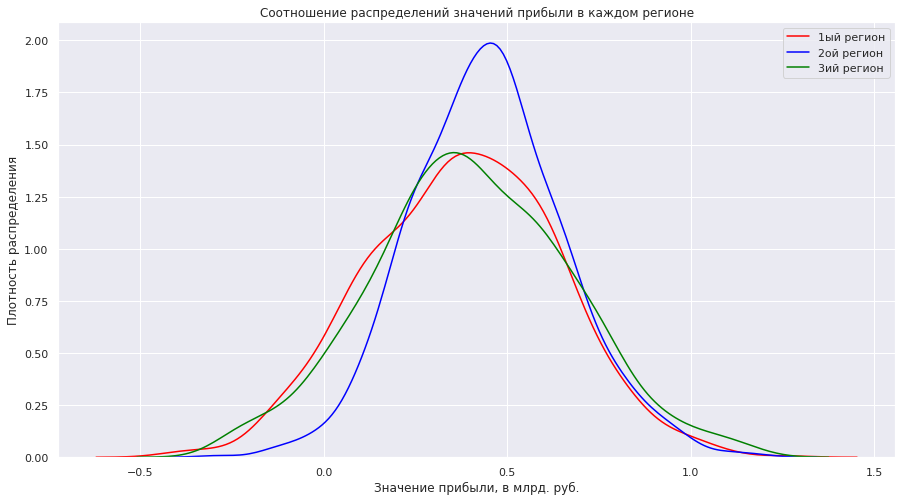

In [117]:
fig, ax = plt.subplots(figsize=(15,8))
ax = sns.kdeplot(t1, color='red', label="1ый регион")
sns.kdeplot(t2, color='blue', label="2ой регион")
sns.kdeplot(t3, color='green', label="3ий регион")

def update(handle, orig):
    handle.update_from(orig)
    handle.set_alpha(1)

plt.legend(
    handler_map={
        PathCollection: HandlerPathCollection(update_func=update),
        plt.Line2D: HandlerLine2D(update_func=update),
    }
)  # видимость в легенде восстанавливаем

plt.ylabel("Плотность распределения")
plt.xlabel("Значение прибыли, в млрд. руб.")
plt.title("Соотношение распределений значений прибыли в каждом регионе")
plt.show()

**Вывод**

По итогу расчетов вышло, что наибольшая средняя выручка может быть получена во втором регионе - 0.45 млрд.руб. Там же - самые низкие риски получения убытков, почти в 5 раз ниже, чем в 1ом и 3ем регионе.

## Вывод

Мы обучили модель линейной регрессии на данных проб нефти из трёх регионов. С помощью обученной модели мы выбирали самые лучшие по предсказаниям скважины и моделировали ситуацию, при которой, знали, сколько нефти будет добыто в конечном итоге. 

С помощью процедуры Bootstrap оценили риски получения убытков для трех регионов, и только второй регион прошел по требованиям заданного риск-порога в 2.5%. Средняя вероятная прибыль в этом регионе при моделировании равна 0.45 млрд. руб. Однако данные проб с этого региона вызывают подозрения и требуют дополнительного разбирательства с ответственными за выгрузку и сбор этих данных или за их синтез. После уточнения данных, потребуется переобучение модели и изучение новых результатов для принятия окончательного решения по выбору региона для разработок.

Если же принять за факт, что с данными всё в порядке, то пригодным для разработки стоит признать только второй регион.

Из рекомендаций: попробовать другие алгоритмы машинного обучения, что, вероятно, может умешить риск убытков в регионах.